In [55]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

sns.set_style('white')
sns.set(font_scale=1.1)

In [56]:
import scipy as sp
from scipy import integrate

In [77]:
class PRFDecoder(object):
    
    def __init__(self, means, sds, weights=None):
        self.means = means
        
        if type(sds) is not list:
            self.sds = [sds] * len(self.means)
        else:
            self.sds = sds
        
        if weights is None:
            self.W = np.identity(len(self.means))
        else:
            W = weights
            
        self.dists = ss.norm(np.log(self.means), self.sds)
#         self.dists = ss.lognorm(scale=np.exp(self.means), s=self.sds)
        self.max = np.max(np.exp(self.dists.ppf(.99)))

    
    def get_response_profile(self, n):
        return self.dists.pdf(np.atleast_2d(np.log(n)).T)
    
    
    def get_bold_distribution(self, n, noise=.1):        
        
        profile = self.get_response_profile(n)
        
        multi = ss.multivariate_normal(self.W.dot(profile.T).ravel(), cov=noise)
        
        return multi
        
    def get_decoding_dist(self, n, noise=0.1, n_=None):
        
        if n_ is None:
            n_ = np.linspace(0, self.max, 1000)
        
        m = self.get_bold_distribution(n, noise)
        p = m.pdf(self.get_response_profile(n_))
        
        den = integrate.quad(lambda x: m.pdf(self.get_response_profile(x)), 0, 3*self.max)[0]
        
        return n_, p / den
        
    def get_response(self, noise=.1):
        pass
    
    def get_random_samples(self, n, noise=0.1, n_=None, num_samples=1000):
        
        n_, p = self.get_decoding_dist(n, noise, n_)        
        i = sp.interpolate.interp1d(np.cumsum(p)/p.sum(), n_)
        
        return i(np.random.rand(num_samples))
        
        

In [60]:
import numpy as np

In [61]:
def get_curves(p, heights):
    heights = heights[:-1]
    heights = np.concatenate((heights, [np.max(p) - np.sum(heights)]))
    
    ones_like_p = np.ones_like(p)
        
    profiles = []
    
    ch = np.concatenate([[0], np.cumsum(heights)])
    
    for i, h in enumerate(heights):
        profile = np.min((p, ch[i] + ones_like_p*h), 0)        
        profiles.append(profile)
        
    return np.array(profiles).T

In [62]:
def get_area_proportions(p, heights):
    profiles = get_curves(p, heights)    
    areas = profiles.sum(0)
    areas -= np.concatenate([[0], areas[:-1]])
    
    return areas / p.sum()

In [63]:
def get_area_parameters(p, proportions):
    
    proportions = np.array(proportions)
    
    print(proportions * p.sum())

    vals = sp.optimize.minimize(fun=lambda x: np.sum((get_area_proportions(p, x) - proportions)**2), x0=proportions * p.max(), method='Nelder-Mead')
    
    return vals.x
    

In [64]:
sns.set_style('white')

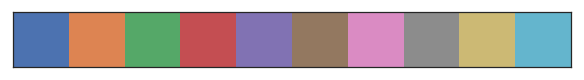

In [9]:
color_order = [3, 1, 2, 0, 4]
sns.palplot(sns.color_palette())

In [10]:
sns.set_palette(np.array(sns.color_palette('deep'))[color_order])

In [65]:
sns.set(font_scale=1.25)
sns.set_style('white')

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


[[2.53282237e-01 6.02503001e+01 3.86194526e+01 6.67030097e-02
  3.10439634e-07]]
[[3.43452059e-09 3.74393999e-03 1.09972488e+01 8.70425571e+01
  1.85640038e+00]]
[[2.63951001e-19 2.59896155e-10 6.89554839e-04 4.92981004e+00
  9.49694617e+01]]
[[13.26971025 31.84770611 29.6601717  10.71884403  1.50314553]]
[[ 0.7875463   7.28232637 26.130214   36.38267114 19.65735052]]
[[2.00647509e-02 5.51261953e-01 5.87707256e+00 2.43132420e+01
  3.90304429e+01]]
2 2.131435281324002 0.5686194280880095
4 4.606743183029119 1.3774243838886657
7 7.177740187665102 1.5254688483011318


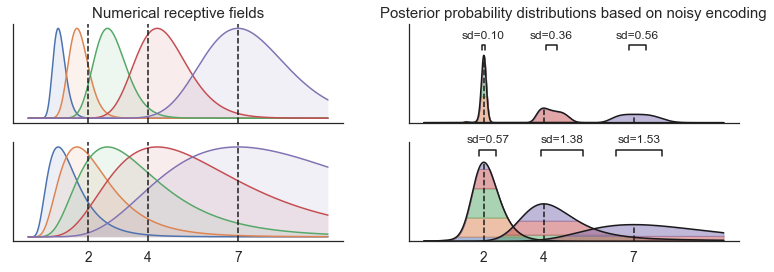

In [123]:
n_ = np.linspace(0, 10, 1000)

scale_second_prf = 2.5

means = np.exp(np.linspace(np.log(1), np.log(7), 5))
sd = .2

x_to_test = [2, 4, 7]

dec = PRFDecoder(means, sd)

plt.subplot(221)
lines = plt.plot(n_, dec.get_response_profile(n_))

for prof in dec.get_response_profile(n_).T:
    plt.fill_between(n_, prof, alpha=.1)

for n in x_to_test:
    plt.axvline(n, c='k', ls='--', alpha=1.)
    
plt.xticks([])

    
plt.yticks([])
plt.title('Numerical receptive fields')
    
plt.subplot(222)
max_p = 0
for n in x_to_test:
    n_, p = dec.get_decoding_dist(n, n_=n_)
        
    max_p = np.max((max_p, p.max()), 0)  
    
    plt.plot([n, n], [0, dec.get_decoding_dist(n, n_=n)[1]], c='k', ls='--')
    plt.plot(n_, p, c='k')
    
    profile = dec.get_response_profile(n)
    profile /= np.sum(profile)
    
    pars = get_area_parameters(p, profile)
    
    curves = get_curves(p, pars)
    curves = np.concatenate((np.zeros((curves.shape[0], 1)), curves), 1)
    
    
    
    for ix in range(1, curves.shape[1]):
        plt.fill_between(n_, curves[:, ix-1], curves[:, ix], color=sns.color_palette()[ix-1], alpha=.5)
for n in x_to_test:
    samples = dec.get_random_samples(n=n, n_=n_)
    mean_posterior = np.mean(samples)
    sd_posterior = np.std(samples)
    x1, x2 = mean_posterior - sd_posterior/2, mean_posterior + sd_posterior/2
    
    l = plt.plot([x1, x1,x2, x2],
             [max_p * 1.075, max_p * 1.15, max_p*1.15, max_p * 1.075], c='k', ls='-', label='std')
    plt.text(mean_posterior, 1.25*max_p, 'sd={:.2f}'.format(sd_posterior), ha='center', fontsize=12)
    
plt.xticks([])
plt.title('Posterior probability distributions based on noisy encoding')
plt.ylim(0, 7)
plt.yticks([])

    
sns.despine()
plt.gcf().set_size_inches(10, 4)

# means = means*scale_second_prf
dec = PRFDecoder(means, sd*scale_second_prf)

plt.subplot(223)
lines = plt.plot(n_, dec.get_response_profile(n_))
plt.yticks([])
plt.xticks(x_to_test)



for prof in dec.get_response_profile(n_).T:
    plt.fill_between(n_, prof, alpha=.1)

for n in x_to_test:
    plt.axvline(n, c='k', ls='--')
    
plt.subplot(224)

max_p = 0

for n in x_to_test:
    n_, p = dec.get_decoding_dist(n, n_=n_)
    
    plt.plot([n, n], [0, dec.get_decoding_dist(n, n_=n)[1]], c='k', ls='--')
    plt.plot(n_, p, c='k')
      
    profile = dec.get_response_profile(n)
    profile /= np.sum(profile)
    
    pars = get_area_parameters(p, profile)
    
    curves = get_curves(p, pars)
    curves = np.concatenate((np.zeros((curves.shape[0], 1)), curves), 1)
    
    max_p = np.max((max_p, p.max()), 0)    
    
    
    for ix in range(1, curves.shape[1]):
        plt.fill_between(n_, curves[:, ix-1], curves[:, ix], color=sns.color_palette()[ix-1], alpha=.5)
    
plt.xticks(x_to_test)
plt.yticks([])
plt.ylim(0, max_p * 1.25)

for n in x_to_test:
    samples = dec.get_random_samples(n=n, n_=n_)
    mean_posterior = np.mean(samples)
    sd_posterior = np.std(samples)
    
    print(n, mean_posterior, sd_posterior)
    
    x1, x2 = mean_posterior - sd_posterior/2, mean_posterior + sd_posterior/2
    l = plt.plot([x1, x1,x2, x2],
             [max_p * 1.075, max_p * 1.15, max_p*1.15, max_p * 1.075], c='k', ls='-', label='std')
    
    plt.text(mean_posterior, 1.25*max_p, 'sd={:.2f}'.format(sd_posterior), ha='center', fontsize=12)
sns.despine()


plt.gcf().set_size_inches(13, 4)
# plt.tight_layout()
plt.savefig('/Users/gilles/Science/grants2/rubicon/figure2a.svg')

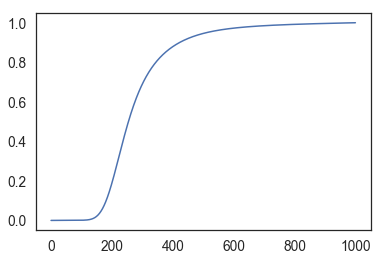

In [32]:
plt.plot()

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


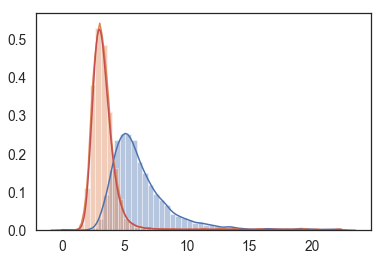

In [95]:
n_ = np.linspace(0, 50, 10000)
n_, p = dec.get_decoding_dist(5)
i = sp.interpolate.interp1d(np.cumsum(p)/p.sum(), n_)

sns.distplot(i(np.random.rand(5000)))

n_ = np.linspace(0, 50, 10000)
n_, p = dec.get_decoding_dist(3)
i = sp.interpolate.interp1d(np.cumsum(p)/p.sum(), n_)
sns.distplot(i(np.random.rand(5000)))

plt.plot(n_, p, c='r')

In [124]:
i(0.95)

array(5.7410536)